## Probabilistic Error Cancellation

In [4]:
#pip install nbconvert

The goal is to evaluate the expectation value of an ideal circuit (made of noiseless gates):
$$
E^{*}(\beta) = Tr[AU_{\beta}(|0><0|^{\otimes{n}})]
$$

with A an observable and $ \beta $ an ideal circuit.

What we can measure with NISQ device, the noisy expectation value of an observable A on the final state produced by a noissy circuit $\alpha $:

$$ E(\alpha) = Tr[AO_{\alpha} (|0><0|^{\otimes{n}})]  $$

with $\alpha$ noisy circuit, $O_{\alpha}$ noisy unitary gate.

The idea is to represent the ideal circuit as a quasi-probabilistic mixture of noisy ones.
$$ U_{\beta} = \gamma_{\beta} \sum_{\alpha \in \Omega_{L}} P_{\beta}(\alpha)\sigma_{\beta}(\alpha) O_{\alpha} $$

with $U_{\beta}$ the ideal gate acting on a density matrix $\rho, \gamma_{\beta}$ the overhead, $\alpha \in \Omega_{L}$ a random variable drawn from $P_{\beta}(\alpha)$.

Then, the ideal expectation value would be evaluated using noisy circuits:

$$ E^{*}(\beta) = \gamma_{\beta} \sum_{\alpha \in \Omega_L} P_{\beta}(\alpha) \sigma_{\beta}(\alpha) E(\alpha)  $$

### The implementation

$$ U_{\beta} = \sum_{\alpha=1}^p \eta_{\alpha} O_{\alpha} $$
$$ O_{\alpha} = D_{1} P U_{\beta} $$
$$ U_{\beta} = \sum_{\alpha=1}^{p} D_{1} P U_{\beta} $$
$$ (D_1)^{-1} =  \sum_{\alpha=1}^p \eta_{\alpha} P $$
$$ (DP)^{-1} = \frac{U_\beta}{O_{\alpha}} = 1 $$


where D is the depolarization channel defined as:
$$ D(\rho) = (1-\epsilon)\rho + \epsilon \frac{Tr(\rho)}{2^n} $$
where we need $\rho$ expressed in Pauli basis: $[\rho_{1}, \rho_{x}, \rho_{y}, \rho_{z}]. $
Here we write D_inv in Pauli basis:

$$
[
D^{-1}=
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & \frac{1}{1-\epsilon} & 0 & 0 \\
    0 & 0 & \frac{1}{1-\epsilon} & 0 \\
    0 & 0 & 0 & \frac{1}{1-\epsilon} \\\
  \end{bmatrix}
]
$$

or equivalently expressed as:
$$
D_{1}^{-1} = \eta_{1}\mathbb{1} + \eta_{2}X + \eta_{3}Y + \eta_{4}Z
$$
where $\eta_{2} = \eta_{3} = \eta_{4} $.

(in the code this matrix is implemented through function depolarization(e, base))

The input state must be expressed as a density matrix (dens function) and then in Pauli basis (state_base2 function). The same goes for the Pauli matrices $(\mathbb{1}, X, Y, Z)$.

First, how do we calculate the Pauli matrices in the Pauli basis? Let's take the X example.
Suppose we have applied the X gate on some state $\rho$.
$$\rho = \mathbb{1}\rho_{1} + \sigma^{x}\rho_{x} + \sigma^{y}\rho_{y} + \sigma^{z}\rho_{z} $$
$$\rho' = \sigma^{x} U^{\dagger}\rho U \sigma^{x}$$
Then:
$$ \sigma^{x} \mathbb{1} \sigma^{x} = \mathbb{1} $$
$$ \sigma^{x} \sigma^{x} \sigma^{x} = \sigma^{x} $$
$$ \sigma^{x} \sigma^{y} \sigma^{x} = -\sigma^{y} $$
$$ \sigma^{x} \sigma^{z} \sigma^{x} = -\sigma^{z} $$

$$
[
X=
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0 \\
    0 & 0 & -1 & 0 \\
    0 & 0 & 0 & -1 \\\
  \end{bmatrix}
]
$$

We do the same for other Pauli matrices in Pauli basis. In this code we have implemented these steps in the  gate_base2 function.

We must also find the $\rho...$ coefficients so that we can express the $\rho$ state properly in the Pauli basis.
We start from the definition:
$$\rho = \mathbb{1}\rho_{1} + \sigma^{x}\rho_{x} + \sigma^{y}\rho_{y} + \sigma^{z}\rho_{z} $$
Every time we multiply this equation with one Pauli matrix and trace the expression in order to receive the corresponding $\rho...$ coefficient. For example, if we multiply both sides of the previous equation by $\sigma^{x}$ and trace it out, we will be able to have an expression for $\rho_{x}$:

$$ Tr[\sigma^{x}\rho] = Tr[\sigma^{x}\rho_{0} + \mathbb{1}\rho_{x} \pm \sigma^{z}\rho_{y} \mp \sigma^{y}\rho_{z}] $$
which gives:
$$ Tr[\sigma_x \rho] = Tr[\mathbb{1} \rho_{x}] $$
$$ \rho_{x} = \frac{1}{2} Tr[\sigma^{x} \rho] $$

We repeat the same process for other components and find each $\rho...$ coefficient the same way. In this code this is implemented in the state_base2 function.
The input state in Pauli basis will be expressed in vectorial form as:
$$rho\_vec = [\rho_{0}, \rho_{x}, \rho_{y}, \rho_{z}] $$

Let's proceed with calculating the inverse depolarization matrix as a quasi-probabilistic combination of the Pauli matrices in Pauli basis.

We plug in our newly found Pauli matrices in this equation:
$$
D_{1}^{-1} = \eta_{1}\mathbb{1} + \eta_{\alpha}X + \eta_{\alpha}Y + \eta_{\alpha}Z
$$

and we find the $\eta$ coefficients which tell us with what probabilities we choose any Pauli gate to represent the inverse of the depolarization matrix. Some $\eta$ coefficients can be negative, which is why we call this method "quasi" probabilistic, instead of "probabilistic". 
These coefficients depend on the probability of having a depolarization error, $\epsilon$:
$$ \eta_{1} = 1 + \frac{3\epsilon}{4(1-\epsilon)} $$
$$ \eta_{\alpha} = -\frac{\epsilon}{4(1-\epsilon)} $$

In this code, I have implemented all these steps in the D_inverse function defined some cells below.

In [8]:
import numpy as np  
from matplotlib import pyplot as plt
import random
from random import randrange
import math

In [9]:
def dens(u1,u2):
    dens=u1*u2
    return dens

In [10]:
u_bra = np.array([[1,0]]) # row vector
u_ket = np.array([[1,0]]).T # column vector
rho=dens(u_ket, u_bra)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Ydag = np.conj(Y).T
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])

In [11]:
def Hadamard(N):
    Hadamard = np.zeros((2**N,2**N))
    for i in range(0, 2**N):
        for j in range(0, 2**N):
            pr = np.bitwise_and(i,j)
            b = np.binary_repr(pr)
            sum=0
            for item in b:
                sum+=int(item)
            ij = sum%2
            Hadamard[i][j]=1/(2**(N/2))*(-1)**(ij)
            
             
    return Hadamard
    


np.ceil(Hadamard(1))
H=Hadamard(1)
H
Hdag = np.transpose(Hadamard(1))

In [12]:
def trace(M):
    t = 0
    for i in range(0,len(M)):
     for j in range(0,len(M)):
        if i==j:
           t += (M[i][j])
        else:
            t += 0
        
    return t

In [13]:
def mul(mat1, mat2):
    return mat1.dot(mat2)

mul(X,X)

def mul3(mat1,mat2,mat3):
    return (mat1.dot(mat2)).dot(mat3)

#### Multiply this expression by X to find coefficient rho_x:

trace(X.dot(rho)) == trace(mul(X,I)* rho_0) + trace(mul(X,X)* rho_x) + trace(mul(X,Y)* rho_y) + trace(mul(X,Z)* rho_z)

#### Inverse of D (depolarization matrix)
Define the ita coefficients that relate the D_inverse matrix with Pauli basis.\
In general, these ita coefficients express the ideal operator U in terms of the noisy operators O.

### Express a state in a new base by calculating the rho_ coefficients of this new base

Here the state is given in computational state as a density matrix between row vector u_bra and column vector u_ket.

In [7]:
from sympy import Symbol, symbols, solve



def state_base2(state, base2):
    

# The symbols represent rho_ coefficients of the base 2
    symbols('r(0:len(base2)')
    coefflist = []
    for i in symbols('r(0:len(base2)'):
        coefflist.append(i)



    rho_prime=0
    for i in range(0,len(base2)):
        rho_prime+=coefflist[i]*(base2[i]) #coefficients * base 2 elements
    eq = rho_prime - rho # equal to 0 # Put everything on one side
    sollist=[]
    for j in range(0, len(base2)):
        expr=trace(mul(base2[j],eq)) # Multiply with a matrix from base 2, and trace
        solution=(solve(expr, coefflist[j])) # Solve for the rho coefficients
        sollist.append(float(solution[0])) # Returns the values of the rho_coefficients
        rho_vec = np.array(sollist)
    print(sollist)
    return rho_vec


state_base2(rho,[I,X,Y,Z])

[0.5, 0.0, 0.0, 0.5]


array([0.5, 0. , 0. , 0.5])

#### A function to convert a matrix/gate from computational basis to any basis

In [8]:
def gate_base2(matrix, base2):

    Matrix_base2 = np.zeros((len(base2),len(base2))) # initialize the matrix we want to find as zeros
    for i in range(0, len(base2)):
        #Multiply U*Baseelement*U
        result=mul3(matrix,base2[i],matrix)
        
        #Very small values like e-17 -> 0 
        for k in range(0,len(result)):
            for l in range(0, len(result)):
                result[k][l]=np.round(result[k][l])
        
        
        #Return coefficients +1 or -1 that connect each element of old and new state in base2
        for j in range(0, len(base2)):
            if (result == base2[j]).all():
                #print(i,j)
                Matrix_base2[i][j]=1
            elif (result == (-1)*base2[j]).all():
                #print(i,-j)
                Matrix_base2[i][j]=-1 
    return Matrix_base2
    

rh=dens(u_ket, u_bra)      
H_pauli=gate_base2(H, [I,X,Y,Z])
#rh=dens(u_ket, u_bra)
gate_base2(X, [I, X, Y, Z])

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1.]])

In [9]:
from itertools import repeat
from sympy.solvers.solveset import linsolve
def depolarization(e, base):
  
    symbols('r(0:len(base2)')
    coefflist = []
    for i in symbols('r0:4'):
        coefflist.append(i)
    coefflist2 = np.array(coefflist)
    
    ###################################
    ### Depolarization matrix
    
    D1 = np.zeros((len(base),len(base))) # initialize the matrix we want to find as zeros
    for i in range(0, len(base)):
     for j in range(0, len(base)):
        if i==j:
            D1[i][j]=1-e
        
    D2 = np.zeros((len(base),len(base))) # initialize the matrix we want to find as zeros
    for i in range(0, len(base)):
     for j in range(0, len(base)):
        if i==0 and j==0:
            D2[i][j]=e
    D12 = D1 + D2       
    return D12
    
    
   

            
    
depolarization(0.1, [I,X,Y,Z]).shape

(4, 4)

In [10]:
def D_inverse(e, base):   
    symbols('r(0:len(base2)')
    coefflist = []
    for i in symbols('r0:4'):
        coefflist.append(i)
    coefflist2 = np.array(coefflist)
    
    ###################################
    ### Depolarization matrix
    
    D1 = np.zeros((len(base),len(base))) # initialize the matrix we want to find as zeros
    for i in range(0, len(base)):
     for j in range(0, len(base)):
        if i==j:
            D1[i][j]=1-e
        
    D2 = np.zeros((len(base),len(base))) # initialize the matrix we want to find as zeros
    for i in range(0, len(base)):
     for j in range(0, len(base)):
        if i==0 and j==0:
            D2[i][j]=e
    D12 = D1 + D2
    
    D_inv = np.zeros((len(base),len(base)))
    for i in range(0, len(base)):
        for j in range(0, len(base)):
            if i==j:
                D_inv[i][j]=D12[i][j]**(-1)
    
    ###################################
    ### Calculate the ita coefficients of the inversed depolarization matrix
    symbols('ita(0:4') # we have two different ita coefficients
    ita_list = []
    for i in symbols('ita0:1'):
        ita_list.append(i)
        ita_list.extend(repeat(symbols('ita1'), len(base)-1))
    ita_list2 = np.array(ita_list)
    

    somelist=[]
    for j in range(0, len(base)):
        somelist.append((ita_list[j]*gate_base2(base[j], base)))
     
    
                    
    Sum = sum(somelist) 
    expr2 = np.subtract(Sum,D_inv)
    
    equations = []
    for i in range(0, len(base)):
        equations.append(expr2[i][i])
    
    ita_list3=[ita_list[0],ita_list[1]]
    ita_solutions=(solve(equations,ita_list3))
    
    ita_values = (list(ita_solutions.values()))
    
    ita_floats=[]
    for i in ita_values:
        ita_floats.append(float(i))
    ita_0 = ita_floats[0]
    ita_1 = ita_floats[1]
    
    ### Express D_inv as ita0*I + ita1*X + ita1*Y + ita1*Z
    
    # First, ita0*I
    D_inv_Pauli_1 = ita_0*gate_base2(base[0], base)
    
    # Then, ita1*X + ita1*Y + ita1*Z
    D_inv_Pauli_2 = np.zeros((len(base),len(base)))
    
    for i in range(1, len(base)):
    
         D_inv_Pauli_2 += ita_1*(gate_base2(base[i], base))
                                 
    D_inv_Pauli = D_inv_Pauli_1 + D_inv_Pauli_2
  
    return D_inv_Pauli

(D_inverse(0.1, [I, X, Y, Z])).shape

(4, 4)

### A channel with a gate + noise, measuring fidelity, inverting noise, correcting fidelity

Here we create a channel which takes a state rho_vec as input, converts it to Pauli basis, applies some gate to it (e.g. a Hadamard gate).
Then it adds depolarizing noise with some probability $\epsilon$. 
We project the fidelity of the $H*\rho$ and $D*H*\rho$. \
The fidelity will be less than 1 due to noise and it will keep decreasing as we perform more shots (circuit executions). \
Then we apply the D_inverse matrix to undo the noise and measure the fidelity again, which will be equal to 1, thus correcting the noise.



[0.5, 0.0, 0.0, 0.5]


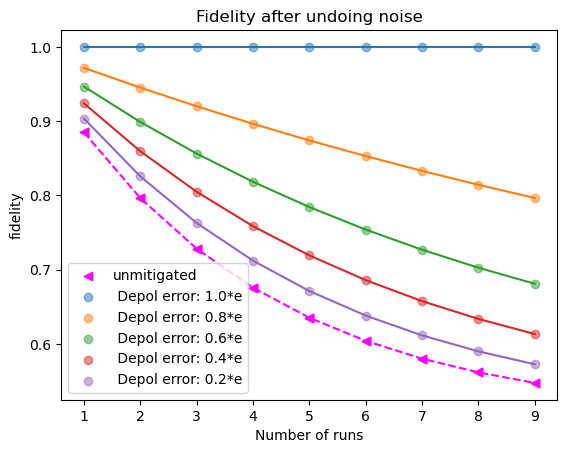

In [11]:
def channel(state, gate, base2, e, N):
    
    ### Express the state as a density matrix
    u_bra = state # row vector
    u_ket = state.T # column vector
    rho = u_ket*u_bra
    #####################################################################
    
    ### Express the gate/matrix in Pauli basis or any basis you define
    Matrix_base2 = gate_base2(gate, base2)
    #return Matrix_base2
    
    #####################################################################


    ### Express the rho state in Pauli basis or any basis of choice
    
    rho_vec = state_base2(state, base2)
    #####################################################################
    ### Apply a gate on the rho state in Pauli basis
    
    rho_new = mul(Matrix_base2, rho_vec) 
     
    
    #####################################################################
    
    ### Plot the fidelity between the noisy state phi_N and noiseless rho_new
    
    nsamples3=[]
    product3=0
    fidelity3=0
    D = depolarization(e, base2)
    
    psi=rho_new #Hadamard*state rho
    
    for i in range(1,N):
        fidelity3=0
        product3=0
        phi_N3=mul(D**i,rho_new) # noisy state (with depolarization)
        for j in range(0, len(phi_N3)):
            product3 += phi_N3[j]*psi[j]
        fidelity3=2*product3
    
    

        nsamples3.append(fidelity3)
    nsamples3

    
    plt.scatter(range(1,N), nsamples3,color='magenta',marker='<', label = "unmitigated")
    plt.plot(range(1,N), nsamples3,'--', color='magenta')
    plt.xlabel('Number of runs')    
    plt.ylabel('fidelity') 
    plt.title('Fidelity for noisy runs')
    
    
    #####################################################################
    
    ### Plot the fidelity after undoing the depolarization noise
    
    nsamples4=[]
    
   
    for k in np.arange(1, 0, -0.2):
        a = k*e
        
    
        D_inv = D_inverse(a, base2)
        
        for i in range(1,N):
            
            fidelity4=0
            product4=0
            phi_N4=mul((mul(D, D_inv)**i),rho_new) # noisy state, but undoing the noise
            for j in range(0, len(phi_N4)):
                product4 += phi_N4[j]*psi[j]
            fidelity4=2*product4
    
            nsamples4.append(fidelity4)
        
        var_k = float("{:.3f}".format(k))
        name = (f" Depol error: {(var_k)}*e")
   

        
        plt.plot(range(1,N), nsamples4)
        plt.scatter(range(1,N), nsamples4, alpha=0.5, label=name)
        
        plt.xlabel('Number of runs')    
        plt.ylabel('fidelity') 
        plt.title('Fidelity after undoing noise')
        plt.savefig('invertnoise.jpg')
        
        plt.legend()
        nsamples4=[]
    plt.scatter(range(1,N), nsamples3,color='magenta',marker='<', label = "unmitigated")
    plt.savefig('invertnoise.jpg')
     
zero = np.array([1,0])
channel(zero, H, [I, X, Y, Z], 0.23, 10)